In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nozzle import Spectral, Params, Nozzle, Boundary
from scipy.integrate import simpson
from scipy.interpolate import BSpline

# Cubic B Spline
Let $ \tilde{v} = \sum_{n=0}^{N} c_nP_n(x) $, where $P_n(x)$ are cubic B spline.

Text(0, 0.5, 'B-Spline')

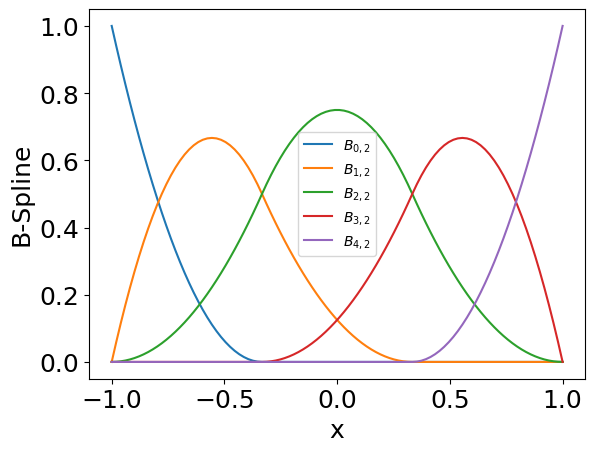

In [42]:
x = np.linspace(-1,1,100)
N = 5 # number basis functions
k = 2 # polynomial degree
t = np.concatenate([-np.ones(k), np.linspace(-1,1,N-k+1) ,np.ones(k)]) # knot vector
c = np.zeros(t.size-k-1) # coefficients
c[-1] = 1
for i in range(t.size-k-1):
    c = np.roll(c,1)
    spline = BSpline(t,c,k)
    plt.plot(x,spline(x), label="$B_{%d,%d}$"%(i,k))
plt.legend(fontsize="medium")
plt.xlabel("x")
plt.ylabel("B-Spline")

## Dirichlet boundary

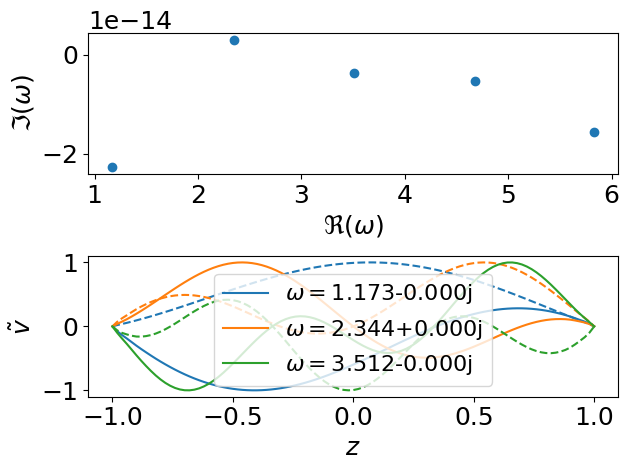

In [73]:
M = 101 # number of points
k = 2 # degree of b-spline
N = 51 # number of basis function
t = np.concatenate([-np.ones(k), np.linspace(-1,1,N-k+1) ,np.ones(k)]) # knot vector
u = lambda x,n: BSpline(t,np.eye(t.size-k-1)[n],k)(x) # basis functions
u_p = lambda x,n: BSpline(t,np.eye(t.size-k-1)[n],k).derivative()(x) # basis functions
u_pp = lambda x,n: BSpline(t,np.eye(t.size-k-1)[n],k).derivative(2)(x) # basis functions

Mm = 0.5
constant_v = True
accelerating = False
boundary = Boundary.FIXED_FIXED
params = Params(Mm, constant_v, accelerating, boundary)

spectral = Spectral(M, "symmetric", "FD")
x = spectral.x
D1 = spectral.D1
D2 = spectral.D2


nozzle = Nozzle(params, x, lambda x,n: u(x,n))
v0 = nozzle.v0

A2 = np.zeros((N,N), dtype=complex)
A1 = np.zeros((N,N), dtype=complex)
A0 = np.zeros((N,N), dtype=complex)
for i in range(N):
    for j in range(N):
        if (i-j) <= k+1:
            A2[i,j] = simpson(u(x,i)*u(x,j),x)
            A1[i,j] = 2j*simpson(u(x,i)*v0*u_p(x,j) + u(x,i)*(D1@v0)*u(x,j),x)
            A0[i,j] = simpson(
                # u(x,i)*(1-v0**2)*u_pp(x,j) -
                -D1@(u(x,i)*(1-v0**2))*u_p(x,j) -
                u(x,i)*(3*v0+1/v0)*(D1@v0)*u_p(x,j) - 
                u(x,i)*(1-1/v0**2)*(D1@v0)**2*u(x,j) -
                u(x,i)*(v0+1/v0)*(D2@v0)*u(x,j),
                x)

C, nozzle.omega = nozzle.solve(A0[1:-1,1:-1],A1[1:-1,1:-1],A2[1:-1,1:-1])
C = np.pad(C, ((1,1),(0,0)))
# C, nozzle.omega = nozzle.solve(A0,A1,A2)
nozzle.V = np.zeros((x.size, C.shape[1]),dtype=complex)
for i in range(C.shape[1]):
    for n in range(N):
            nozzle.V[:,i] += C[n,i]*u(x, n)
nozzle.sort_solutions(real_range=[0.1,6], imag_range=[-1,1])

fig, ax = plt.subplots(2,1)
nozzle.plot_eigenvalues(ax=ax[0])
nozzle.plot_eigenfunctions(num_funcs=3,ax=ax[1])
plt.tight_layout()
nozzle.save_data("FE", N=N)

## Open right end

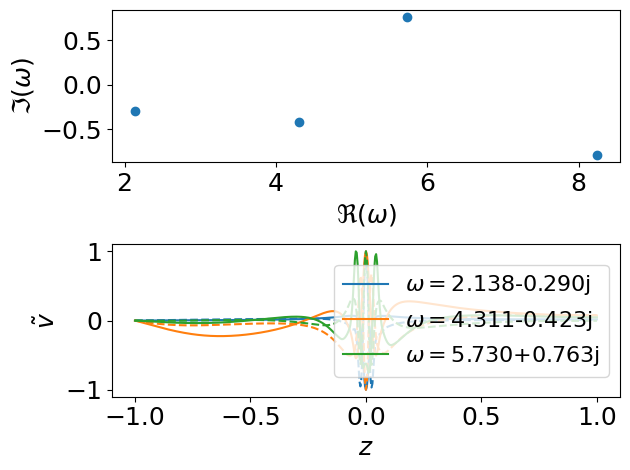

In [84]:
M = 501 # number of points
k = 2 # degree of b-spline
N = 101 # number of basis function
t = np.concatenate([-np.ones(k), np.linspace(-1,1,N-k+1) ,np.ones(k)]) # knot vector
u = lambda x,n: BSpline(t,np.eye(t.size-k-1)[n],k)(x) # basis functions
u_p = lambda x,n: BSpline(t,np.eye(t.size-k-1)[n],k).derivative()(x) # basis functions
u_pp = lambda x,n: BSpline(t,np.eye(t.size-k-1)[n],k).derivative(2)(x) # basis functions

Mm = 1.0
constant_v = False
accelerating = True
boundary = Boundary.FIXED_OPEN
params = Params(Mm, constant_v, accelerating, boundary)

spectral = Spectral(M, "symmetric", "FD")
x = spectral.x
D1 = spectral.D1
D2 = spectral.D2


nozzle = Nozzle(params, x, lambda x,n: u(x,n))
v0 = nozzle.v0

A2 = np.zeros((N-1,N-1), dtype=complex) # n from -1 to N+1
A1 = np.zeros((N-1,N-1), dtype=complex)
A0 = np.zeros((N-1,N-1), dtype=complex)
for i in range(N-1):
    for j in range(N-1):
        if np.abs(i-j) <= 3:
            A2[i,j] = simpson(u(x,i)*u(x,j),x)
            A1[i,j] = 2j*simpson(u(x,i)*v0*u_p(x,j) + u(x,i)*(D1@v0)*u(x,j),x)
            A0[i,j] = simpson(
                u(x,i)*(1-v0**2)*u_pp(x,j) -
                u(x,i)*(3*v0+1/v0)*(D1@v0)*u_p(x,j) - 
                u(x,i)*(1-1/v0**2)*(D1@v0)**2*u(x,j) -
                u(x,i)*(v0+1/v0)*(D2@v0)*u(x,j),
                x)

            # open right end condition
            A2[i,j] -= u_p(1,j)/u_p(1,N-1)*simpson(u(x,i)*u(x,N-1),x)
            A1[i,j] -= 2j*u_p(1,j)/u_p(1,N-1)*simpson(u(x,i)*(v0*u_p(x,N-1)+(D1@v0)*u(x,N-1)),x)
            A0[i,j] -= u_p(1,j)/u_p(1,N-1)*simpson(
                    u(x,i)*(1-v0**2)*u_pp(x,N-1) -
                    u(x,i)*(3*v0+1/v0)*(D1@v0)*u_p(x,N-1) - 
                    u(x,i)*(1-1/v0**2)*(D1@v0)**2*u(x,N-1) -
                    u(x,i)*(v0+1/v0)*(D2@v0)*u(x,N-1),
                    x)

# nozzle.solve(A0,A1,A2)
C, nozzle.omega = nozzle.polyeig(A0[1:,1:],A1[1:,1:],A2[1:,1:])
C = np.pad(C, ((1,0),(0,0)))
nozzle.V = np.zeros((x.size, C.shape[1]),dtype=complex)
for i in range(C.shape[1]):
    for n in range(N):
        if (n<N-1):
            nozzle.V[:,i] += C[n,i]*u(x, n)
        else:
            c_last = -np.sum([C[k,i]*u_p(1,k) for k in range(N-1)])/u_p(1,N-1)
            nozzle.V[:,i] += c_last*u(x, N-1)
nozzle.sort_solutions(real_range=[0.1,10], imag_range=[-1,1])

fig, ax = plt.subplots(2,1)
nozzle.plot_eigenvalues(ax=ax[0])
nozzle.plot_eigenfunctions(num_funcs=3,ax=ax[1])
plt.tight_layout()

nozzle.save_data("FE", N=N)